In [2]:
import tensorflow as tf
print(tf.keras.__version__)

2.4.0


# KERAS 2 CMSIS



In [17]:
import tensorflow as tf


mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1) ),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu',),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(64, activation='linear'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10)
model.evaluate(x_test, y_test)
model.summary()
model.save('model.keras')


Epoch 1/10
1875/1875 [==============================] - 20s 10ms/step - loss: 0.1510 - accuracy: 0.9546
Epoch 2/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0541 - accuracy: 0.9840
Epoch 3/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0413 - accuracy: 0.9872
Epoch 4/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0315 - accuracy: 0.9904
Epoch 5/10
1875/1875 [==============================] - 20s 10ms/step - loss: 0.0269 - accuracy: 0.9916
Epoch 6/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0206 - accuracy: 0.9931
Epoch 7/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0177 - accuracy: 0.9942
Epoch 8/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0165 - accuracy: 0.9942
Epoch 9/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0133 - accuracy: 0.9956
Epoch 10/10
313/313 [==============================] - 1s 3ms/ste

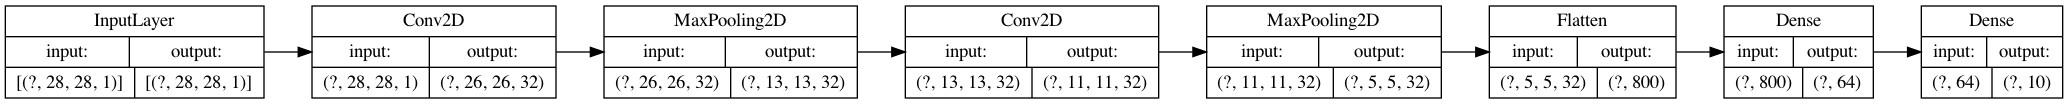

In [26]:
from keras.utils import plot_model
plot_model(model,
    show_layer_names=False, show_shapes=True, rankdir='LR', expand_nested=True, to_file='model.png')

# Generate code in c for cmsis

In [19]:
import keras as k
import numpy as np



In [20]:
for layer in model.layers:
    layer_no=model.layers.index(layer)
    if(layer_no>0):
        prev_layer=model.layers[layer_no-1]
    print(layer.__class__.__name__)
    

Conv2D
MaxPooling2D
Conv2D
MaxPooling2D
Flatten
Dense
Dense


In [21]:
def convert_q7_q15_weights(weights):
    [r, h, w, c] = weights.shape
    weights = np.reshape(weights, (r, h*w*c))
    num_of_rows = r
    num_of_cols = h*w*c
    new_weights = np.copy(weights)
    new_weights = np.reshape(new_weights, (r*h*w*c))
    counter = 0
    for i in range(int(num_of_rows/4)):
      # we only need to do the re-ordering for every 4 rows
      row_base = 4*i
      for j in range (int(num_of_cols/2)):
        # for each 2 entries
        column_base = 2*j
        new_weights[counter]   =  weights[row_base  ][column_base  ]
        new_weights[counter+1] =  weights[row_base+1][column_base  ]
        new_weights[counter+2] =  weights[row_base  ][column_base+1]
        new_weights[counter+3] =  weights[row_base+1][column_base+1]
        new_weights[counter+4] =  weights[row_base+2][column_base  ]
        new_weights[counter+5] =  weights[row_base+3][column_base  ]
        new_weights[counter+6] =  weights[row_base+2][column_base+1]
        new_weights[counter+7] =  weights[row_base+3][column_base+1]

        counter = counter + 8
      # the remaining ones are in order
      for j in range((int)(num_of_cols-num_of_cols%2), int(num_of_cols)):
        new_weights[counter] = weights[row_base][j]
        new_weights[counter+1] = weights[row_base+1][j]
        new_weights[counter+2] = weights[row_base+2][j]
        new_weights[counter+3] = weights[row_base+3][j]
        counter = counter + 4
    return new_weights


In [22]:
def findQR(intBits):
    """ Calculate the range, given the number of integer bits QM.N

    intBits: number of bits used for integer part
    """
    M = intBits
    N = fixPointBits - M
    [minVal, maxVal] = [-2**(M - 1), (2**(M - 1) - 2**(-N))]
    return [minVal, maxVal]


def findQRangeOfWeights(weights):
    """ Finds the Q Range which does not clip the weights

    weights: float values of which the ideal Q range is searched
    returns: number of integer bits required to represent "weights"
    """
    qRange = [None]*(fixPointBits + 1)
    for bit in range(0, fixPointBits + 1):
        qRange[bit] = findQR(bit)

    minValue = weights.min()
    maxValue = weights.max()
    highestVal = max(abs(minValue), abs(maxValue))
    for bit in range(0, fixPointBits + 1):
        if highestVal < qRange[bit][1]:
            # highestVal fits in the range
            # return number of integer bits required
            return bit

In [23]:
numberOfWeightArray = 0
weightDecBits = []
intWeightsAndBias = []

fixPointBits=7


# quantize layer by layer
for layer in model.layers:
    if 'activation' in layer.name:
        continue
    print('Quantisize weights of layer: ' + layer.name)

    weightsArray = layer.get_weights()

    # dense layer has 2 numpy arrays with weights, the matrix weights and the bias: [w, b]
    for weights in weightsArray:

        intBit = findQRangeOfWeights(weights)

        # if we have q15 we can buffer the int bits. This increases stability
        # in q7 mode this does sometimes decrease the accuracy to much
        if fixPointBits == 15:
            intBit = intBit + 2

        elif (fixPointBits == 7) and (intBit == 0):
            intBit = 1

        decBit = fixPointBits - intBit
        weightDecBits.append(decBit)

        # convert to q format using same method as ARM [1]
        intWeights = np.round(weights * 2**decBit)

        # saturate range inside q7 or q15 to prevent sign cast in C code
        intWeights[intWeights > 2**fixPointBits -1] = 2**fixPointBits - 1
        intWeights[intWeights < -2**fixPointBits] = - 2**fixPointBits

        # store int16 or int8 values
        intWeightsAndBias.append(intWeights)

        print('WeightsArrayNr_'+str(numberOfWeightArray) +
              ': Q' + str(fixPointBits - weightDecBits[numberOfWeightArray]) +
              '.' + str(weightDecBits[numberOfWeightArray]))
        numberOfWeightArray = numberOfWeightArray + 1

Quantisize weights of layer: conv2d_4
WeightsArrayNr_0: Q1.6
WeightsArrayNr_1: Q1.6
Quantisize weights of layer: max_pooling2d_4
Quantisize weights of layer: conv2d_5
WeightsArrayNr_2: Q1.6
WeightsArrayNr_3: Q1.6
Quantisize weights of layer: max_pooling2d_5
Quantisize weights of layer: flatten_2
Quantisize weights of layer: dense_4
WeightsArrayNr_4: Q1.6
WeightsArrayNr_5: Q1.6
Quantisize weights of layer: dense_5
WeightsArrayNr_6: Q1.6
WeightsArrayNr_7: Q1.6


In [24]:
for layer in model.layers:
    print(layer.name)

conv2d_4
max_pooling2d_4
conv2d_5
max_pooling2d_5
flatten_2
dense_4
dense_5


In [25]:
fp = 'keras-weights.h'
print('Write weights and net parameters into:' + fp)
with open(fp, 'w') as f:

    for layer in model.layers:
        if 'activation' in layer.name:
            continue
        print('Quantisize weights of layer: ' + layer.name)

        weightsArray = layer.get_weights()
        
        if 'conv' in layer.name:
            write_name = layer.name.upper()
        else:
            write_name = 'IP1'

        idx =0
        bias = '_WT'
        for weight in weightsArray:
            min_wt = weight.min() 
            max_wt = weight.max()
            #find number of integer bits to represent this range
            int_bits = int(np.ceil(np.log2(max(abs(min_wt),abs(max_wt))))) 
            frac_bits = 7-int_bits #remaining bits are fractional bits (1-bit for sign)
            #floating point weights are scaled and rounded to [-128,127], which are used in 
            #the fixed-point operations on the actual hardware (i.e., microcontroller)
            quant_weight = np.round(weight*(2**frac_bits))
            #To quantify the impact of quantized weights, scale them back to
            # original range to run inference using quantized weights
            weight = quant_weight/(2**frac_bits)
    #         print(quant_weight)
            f.write('#define '+write_name+bias+' {')
            np.transpose(quant_weight).tofile(
                f, sep=", ", format="%d")
            f.write('}\n')
            if 'BIAS' in bias:
                f.write('#define '+write_name+'_BIAS_LSHIFT '+str(frac_bits-7)+'\n')
            else:
                f.write('#define '+write_name+'_OUT_RSHIFT '+str(frac_bits-7)+'\n')
            bias ='_BIAS'
            print(frac_bits)


Write weights and net parameters into:keras-weights.h
Quantisize weights of layer: conv2d_4
Quantisize weights of layer: max_pooling2d_4
Quantisize weights of layer: conv2d_5
Quantisize weights of layer: max_pooling2d_5
Quantisize weights of layer: flatten_2
Quantisize weights of layer: dense_4
Quantisize weights of layer: dense_5


In [8]:
file_name = 'keras-parameter.h'
print('Generating parameter file: '+file_name)
f=open(file_name,'w')

for layer in model.layers:
    layer_no=model.layers.index(layer)
    if(layer_no>0):
        prev_layer=model.layers[layer_no-1]
    print(layer.__class__.__name__)
#     if caffe_model.layer_type[layer]=='data' or  caffe_model.layer_type[layer]=='5':
#         f.write("#define "+layer.upper()+"_OUT_CH "+str(caffe_model.layer_shape[layer][1])+"\n")
#         f.write("#define "+layer.upper()+"_OUT_DIM "+str(caffe_model.layer_shape[layer][2])+"\n\n")
    if layer.__class__.__name__=='Conv2D':
        LAYER=layer.name.upper()
        f.write("#define "+LAYER+"_IN_DIM "+str(layer.input_shape[1])+"\n")
        f.write("#define "+layer.name.upper()+"_IN_CH "+str(layer.input_shape[3])+"\n")
        f.write("#define "+layer.name.upper()+"_KER_DIM "+str(layer.kernel_size[1])+"\n")
        f.write("#define "+layer.name.upper()+"_PAD "+str(0)+"\n")
        f.write("#define "+layer.name.upper()+"_STRIDE "+str(layer.strides[1])+"\n")
        f.write("#define "+layer.name.upper()+"_OUT_CH "+str(layer.output_shape[3])+"\n\n")
        f.write("#define "+layer.name.upper()+"_OUT_DIM "+str(layer.output_shape[2])+"\n\n") 

#     elif caffe_model.layer_type[layer]=='relu' or caffe_model.layer_type[layer]=='18':
#         f.write("#define "+layer.upper()+"_OUT_CH "+str(caffe_model.layer_shape[layer][1])+"\n")
#         f.write("#define "+layer.upper()+"_OUT_DIM "+str(caffe_model.layer_shape[layer][2])+"\n\n")
    elif layer.__class__.__name__=='MaxPooling2D':
        f.write("#define "+layer.name.upper()+"_IN_DIM "+str(layer.input_shape[1])+"\n")
        f.write("#define "+layer.name.upper()+"_IN_CH "+str(layer.input_shape[3])+"\n")
        f.write("#define "+layer.name.upper()+"_KER_DIM "+str(layer.pool_size[1])+"\n")
        f.write("#define "+layer.name.upper()+"_PAD "+str(0)+"\n")
        f.write("#define "+layer.name.upper()+"_STRIDE "+str(layer.strides[1])+"\n")
        f.write("#define "+layer.name.upper()+"_OUT_DIM "+str(layer.output_shape[2])+"\n\n")
    elif  layer.__class__.__name__=='Dense':
        f.write("#define IP1_DIM "+str(layer.input_shape[1])+"\n")
        f.write("#define IP1_OUT "+str(layer.output_shape[1])+"\n")
        
        
#         f.write("#define "+layer.upper()+"_IN_DIM "+str(caffe_model.layer_shape[prev_layer][2])+"\n")
#         f.write("#define "+layer.upper()+"_IN_CH "+str(caffe_model.layer_shape[prev_layer][1])+"\n")
#         f.write("#define "+layer.upper()+"_KER_DIM "+str(caffe_model.kernel_size[layer])+"\n")
#         f.write("#define "+layer.upper()+"_STRIDE "+str(caffe_model.stride[layer])+"\n")
#         f.write("#define "+layer.upper()+"_PAD "+str(caffe_model.pad[layer])+"\n")
#         f.write("#define "+layer.upper()+"_OUT_DIM "+str(caffe_model.layer_shape[layer][2])+"\n\n")
#     elif caffe_model.layer_type[layer]=='innerproduct' or  caffe_model.layer_type[layer]=='14':
#         f.write("#define "+layer.upper()+"_IN_DIM "+str(caffe_model.layer_shape[prev_layer][1]*\
#                 caffe_model.layer_shape[prev_layer][2]*caffe_model.layer_shape[prev_layer][3])+"\n")
#         f.write("#define "+layer.upper()+"_OUT_DIM "+str(caffe_model.layer_shape[layer][1])+"\n\n")
# f.write("#define DATA_RSHIFT "+str(caffe_model.act_dec_bits[caffe_model.data_layer])+"\n")
# for layer in caffe_model.conv_layer+caffe_model.ip_layer:
#     f.write("#define "+layer.upper()+"_BIAS_LSHIFT " + str(caffe_model.bias_lshift[layer])+"\n")
#     f.write("#define "+layer.upper()+"_OUT_RSHIFT " + str(caffe_model.act_rshift[layer])+"\n")







f.close()

Generating parameter file: keras-parameter.h
Conv2D
MaxPooling2D
Conv2D
MaxPooling2D
Flatten
Dense


In [9]:

file_name = 'keras-dnn.h'
model = k.models.load_model('model.keras')
print('Generating file: '+file_name)
f=open(file_name,'w')
f.write('\
#include "keras-weights.h"\n\
#include "keras-parameter.h"\n\
void run_nn(q7_t* input_data);\n\n\
')





for layer in model.layers:
    print (layer.name)
    if layer.__class__.__name__=='Conv2D':
        f.write("static q7_t "+layer.name+"_wt["+layer.name.upper()+"_IN_CH*"+layer.name.upper()+"_KER_DIM*"+\
                layer.name.upper()+"_KER_DIM*"+layer.name.upper()+"_OUT_CH] = "+layer.name.upper()+"_WT;\n")
        f.write("static q7_t "+layer.name+"_bias["+layer.name.upper()+"_OUT_CH] = "+layer.name.upper()+"_BIAS;\n\n")
    elif layer.__class__.__name__=='Flatten':
            f.write("static q7_t ip1_wt[IP1_DIM * IP1_OUT] = IP1_WT;\n")
            f.write("static q7_t ip1_bias[IP1_OUT] = IP1_BIAS;\n\n")
        # for layer in model.ip_layer:
#     f.write("static q7_t "+layer+"_wt["+layer.upper()+"_IN_DIM*"+layer.upper()+"_OUT_DIM] = "+\
#             layer.upper()+"_WT;\n")
#     f.write("static q7_t "+layer+"_bias["+layer.upper()+"_OUT_DIM] = "+layer.upper()+"_BIAS;\n\n")


currHighest = 1
currHighest2 = 1
for layer in model.layers[0:len(model.layers)]:
    if "conv" in layer.name:
        print(layer.output_shape)
        y = 1
        for x in layer.output_shape:
            if x is not None:
                y = y * x
        if y > currHighest:
            currHighest = y
    if "max_pooling"  in layer.name:
        y = 1
        for x in layer.output_shape:
            if x is not None:
                y = y * x
        if y > currHighest2:
            currHighest2 = y
            
f.write('static q7_t max_buffer1['+str(currHighest)+'];\n')

f.write('static q7_t max_buffer2['+str(currHighest2)+'];\n')
f.write('static q7_t output_data[IP1_OUT];\n\n')


lay = model.layers[0:len(model.layers)][0].name.upper()


f.write('static q7_t col_buffer[2*'+lay+'_KER_DIM*'+lay+'_KER_DIM*'+lay+'_IN_CH];\n')




f.write('\nvoid run_nn(uint8_t* input_data) {\n')
f.write('  q7_t* buffer1 = max_buffer1;\n')
f.write('  q7_t* buffer2 = max_buffer2;\n')


flag = 1
for layer in model.layers:
    LAYER = layer.name.upper()
    if layer.__class__.__name__=='Conv2D':
        if flag == 1:
            conv_func = 'arm_convolve_HWC_q7_basic'
            f.write('  '+conv_func+'((q7_t*)input_data'+', '+LAYER+'_IN_DIM, '+LAYER+\
                            '_IN_CH, '+LAYER.lower()+'_wt, '+LAYER+'_OUT_CH, '+LAYER+'_KER_DIM, '+LAYER+'_PAD, '\
                            +LAYER+'_STRIDE, '+LAYER.lower()+'_bias, '+LAYER+'_BIAS_LSHIFT, '+LAYER+'_OUT_RSHIFT, '\
                            +'buffer1, '+LAYER+'_OUT_DIM, (q15_t*)col_buffer, NULL);\n')
            f.write('  arm_relu_q7('+'buffer1'+', '+LAYER+'_OUT_DIM*'+LAYER+'_OUT_DIM*'+\
                   LAYER+'_OUT_CH);\n')
            flag = 0
        else:
            conv_func = 'arm_convolve_HWC_q7_fast'
            f.write('  '+conv_func+'(buffer2'+', '+LAYER+'_IN_DIM, '+LAYER+\
                            '_IN_CH, '+LAYER.lower()+'_wt, '+LAYER+'_OUT_CH, '+LAYER+'_KER_DIM, '+LAYER+'_PAD, '\
                            +LAYER+'_STRIDE, '+LAYER.lower()+'_bias, '+LAYER+'_BIAS_LSHIFT, '+LAYER+'_OUT_RSHIFT, '\
                            +'buffer1, '+LAYER+'_OUT_DIM, (q15_t*)col_buffer, NULL);\n')
            f.write('  arm_relu_q7('+'buffer1'+', '+LAYER+'_OUT_DIM*'+LAYER+'_OUT_DIM*'+\
                   LAYER+'_OUT_CH);\n')
            
    elif layer.__class__.__name__=='MaxPooling2D':
        pool_func='arm_maxpool_q7_HWC'
        f.write('  '+pool_func+'('+'buffer1'+', '+LAYER+'_IN_DIM, '+LAYER+'_IN_CH, '+\
            LAYER+'_KER_DIM, '+LAYER+'_PAD, '+LAYER+'_STRIDE, '+LAYER+'_OUT_DIM, col_buffer, '+\
            'buffer2'+');\n\n')
        
    elif  layer.__class__.__name__=='Dense':
        f.write('  arm_fully_connected_q7_opt(buffer2, ip1_wt, IP1_DIM, IP1_OUT, IP1_BIAS_LSHIFT, IP1_OUT_RSHIFT, ip1_bias, output_data, (q15_t*)col_buffer);\n')
        f.write('  arm_softmax_q7(output_data, 10, output_data); \n')
f.write('}')
f.close()

Generating file: keras-dnn.h
conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
flatten
dense
(None, 26, 26, 64)
(None, 11, 11, 64)
